In [1]:
import os, random, json, pickle
import numpy as np
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [3]:
DATA_DIR = "/content/drive/MyDrive/UrbanSound_Preprocessed"

X = np.load(os.path.join(DATA_DIR, "X_mel.npy"))
y = np.load(os.path.join(DATA_DIR, "y_labels.npy"))
folds = np.load(os.path.join(DATA_DIR, "folds.npy"))

with open(os.path.join(DATA_DIR, "preprocessing_params.json"), "r") as f:
    params = json.load(f)

with open(os.path.join(DATA_DIR, "label_encoder.pkl"), "rb") as f:
    label_encoder = pickle.load(f)

class_names = params["class_names"]
input_shape = tuple(params["input_shape"])
num_classes = len(class_names)

print("Shapes cargados:")
print("X:", X.shape)
print("y:", y.shape)
print("input_shape:", input_shape)
print("Clases:", class_names)

Shapes cargados:
X: (8732, 128, 173, 1)
y: (8732,)
input_shape: (128, 173, 1)
Clases: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [4]:
train_idx = np.isin(folds, list(range(1, 9)))
val_idx = folds == 9
test_idx = folds == 10

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Train:", X_train.shape[0])
print("Val:", X_val.shape[0])
print("Test:", X_test.shape[0])

Train: 7079
Val: 816
Test: 837


In [5]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(Xa, ya, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((Xa, ya))
    if shuffle:
        ds = ds.shuffle(len(Xa), seed=SEED)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds   = make_dataset(X_val, y_val)
test_ds  = make_dataset(X_test, y_test)

In [6]:
def plot_history(history, title="Modelo"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(title + " Accuracy")
    plt.legend(["train", "val"])

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(title + " Loss")
    plt.legend(["train", "val"])
    plt.show()


def evaluate_model(model, Xdata, ydata, name="model"):
    preds = model.predict(Xdata, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    print("Classification Report -", name)
    print(classification_report(ydata, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(ydata, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap="Blues", annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix - " + name)
    plt.show()

    return preds

In [7]:
def train_and_save(model, name):
    ckpt = f"/content/models/{name}_best.h5"

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=6, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            ckpt, monitor="val_accuracy", save_best_only=True
        )
    ]

    h = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=callbacks)

    # Guardar también pesos compatibles con SavedModel
    model.save_weights(f"/content/models/{name}_best.weights.h5")

    return h, ckpt


Epoch 1/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1975 - loss: 2.1627

222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1976 - loss: 2.1623 - val_accuracy: 0.2243 - val_loss: 1.8416
Epoch 2/40
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2403 - loss: 1.9534

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2403 - loss: 1.9536 - val_accuracy: 0.2500 - val_loss: 1.8299
Epoch 3/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2404 - loss: 1.9560 - val_accuracy: 0.2181 - val_loss: 1.8161
Epoch 4/40
210/222 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2538 - loss: 1.9320

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2534 - loss: 1.9327 - val_accuracy: 0.2549 - val_loss: 1.8035
Epoch 5/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2565 - loss: 1.9391 - val_accuracy: 0.2451 - val_loss: 1.8193
Epoch 6/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2502 - loss: 1.9454 - val_accuracy: 0.2255 - val_loss: 1.8240
Epoch 7/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2395 - loss: 1.9536 - val_accuracy: 0.2034 - val_loss: 1.8128
Epoch 8/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2498 - loss: 1.9258 - val_accuracy: 0.2390 - val_loss: 1.8288
Epoch 9/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2511 - loss: 1.9288 - val_accuracy: 0.2132 - val_loss: 1.8400
Epoch 10/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2476 - loss: 1.9501 - val_accuracy: 0.2218 - val_loss: 1.8166


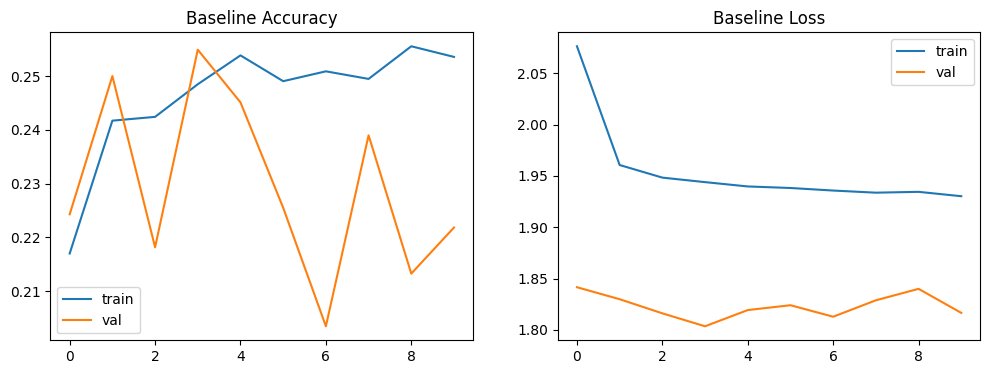

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def build_baseline(input_shape, num_classes):
    model = Sequential([
        GlobalAveragePooling2D(input_shape=input_shape),
        Dense(256, activation="relu"),
        Dropout(0.4),
        Dense(256, activation="relu"),
        Dropout(0.4),
        Dense(128, activation="relu"),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

baseline = build_baseline(input_shape, num_classes)
hist_base, ckpt_base = train_and_save(baseline, "baseline")
plot_history(hist_base, "Baseline")

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2437 - loss: 3.8490

222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.2439 - loss: 3.8429 - val_accuracy: 0.1324 - val_loss: 15.2637
Epoch 2/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3596 - loss: 1.7473

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.3599 - loss: 1.7465 - val_accuracy: 0.3836 - val_loss: 3.2331
Epoch 3/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4646 - loss: 1.4695

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4648 - loss: 1.4690 - val_accuracy: 0.5760 - val_loss: 1.9942
Epoch 4/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5346 - loss: 1.2799

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5348 - loss: 1.2796 - val_accuracy: 0.5956 - val_loss: 1.4047
Epoch 5/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6029 - loss: 1.1229

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6031 - loss: 1.1227 - val_accuracy: 0.6360 - val_loss: 1.8922
Epoch 6/40
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6607 - loss: 0.9790

222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6610 - loss: 0.9784 - val_accuracy: 0.6483 - val_loss: 1.9775
Epoch 7/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7054 - loss: 0.8349

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7056 - loss: 0.8345 - val_accuracy: 0.6826 - val_loss: 2.1089
Epoch 8/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7538 - loss: 0.7096 - val_accuracy: 0.6605 - val_loss: 2.3276
Epoch 9/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7901 - loss: 0.6039 - val_accuracy: 0.6789 - val_loss: 1.4546
Epoch 10/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8256 - loss: 0.5220

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8256 - loss: 0.5220 - val_accuracy: 0.7377 - val_loss: 1.6628


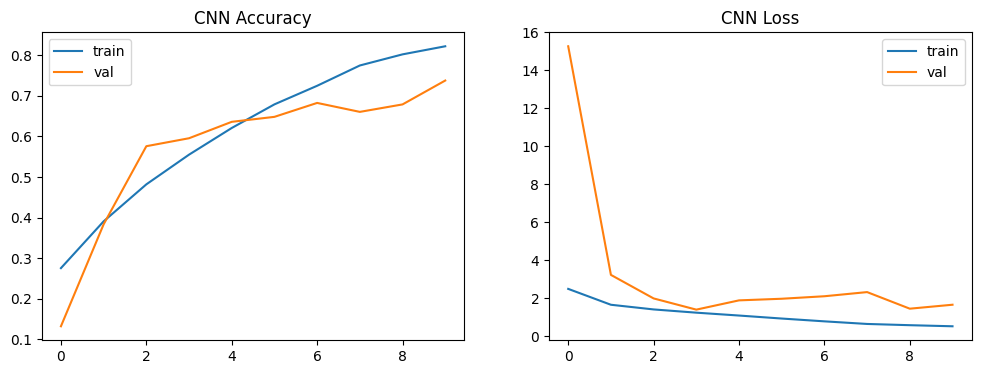

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation="relu",padding='same', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation="relu",padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(256, (3,3), activation="relu", padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

cnn = build_cnn(input_shape, num_classes)
hist_cnn, ckpt_cnn = train_and_save(cnn, "cnn")
plot_history(hist_cnn, "CNN")


Epoch 1/40
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2062 - loss: 2.1004

222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2067 - loss: 2.0989 - val_accuracy: 0.2500 - val_loss: 1.7760
Epoch 2/40
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2714 - loss: 1.8505

222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2716 - loss: 1.8501 - val_accuracy: 0.3321 - val_loss: 1.7090
Epoch 3/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3248 - loss: 1.7210 - val_accuracy: 0.3321 - val_loss: 1.5883
Epoch 4/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3802 - loss: 1.6190 - val_accuracy: 0.3088 - val_loss: 1.6897
Epoch 5/40
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4094 - loss: 1.5310

222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4098 - loss: 1.5305 - val_accuracy: 0.4020 - val_loss: 1.5902
Epoch 6/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4597 - loss: 1.4122 - val_accuracy: 0.3971 - val_loss: 1.6125
Epoch 7/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5124 - loss: 1.3102 - val_accuracy: 0.3897 - val_loss: 1.4933
Epoch 8/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5375 - loss: 1.2446

222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5375 - loss: 1.2445 - val_accuracy: 0.4412 - val_loss: 1.5526
Epoch 9/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5607 - loss: 1.2223 - val_accuracy: 0.4375 - val_loss: 1.5658
Epoch 10/40
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5985 - loss: 1.1259

222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5986 - loss: 1.1258 - val_accuracy: 0.4902 - val_loss: 1.4334
Epoch 11/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6215 - loss: 1.0698 - val_accuracy: 0.4608 - val_loss: 1.4287
Epoch 12/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6380 - loss: 1.0095 - val_accuracy: 0.4645 - val_loss: 1.5705
Epoch 13/40
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6575 - loss: 0.9663

222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6575 - loss: 0.9663 - val_accuracy: 0.5429 - val_loss: 1.3653
Epoch 14/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6880 - loss: 0.8902

222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6880 - loss: 0.8903 - val_accuracy: 0.5564 - val_loss: 1.3286
Epoch 15/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7202 - loss: 0.8185 - val_accuracy: 0.4951 - val_loss: 1.4551
Epoch 16/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7173 - loss: 0.8120 - val_accuracy: 0.5294 - val_loss: 1.4926
Epoch 17/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7269 - loss: 0.7676 - val_accuracy: 0.4681 - val_loss: 1.7147
Epoch 18/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7586 - loss: 0.7044 - val_accuracy: 0.5355 - val_loss: 1.5427
Epoch 19/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7701 - loss: 0.6889 - val_accuracy: 0.5429 - val_loss: 1.5159
Epoch 20/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7790 - loss: 0.6426 - val_accuracy: 0.5551 - val_loss: 1.5889


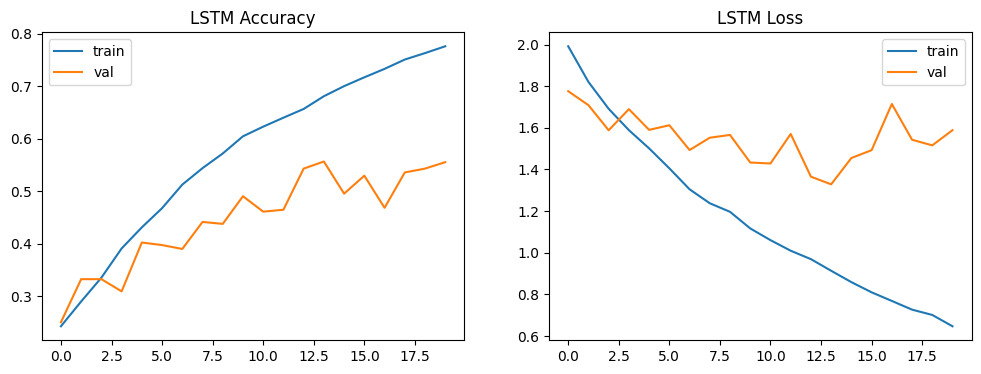

In [13]:
from tensorflow.keras import layers, models

def build_lstm_model(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)

    mel_bins = input_shape[0]
    frames = input_shape[1]

    x = layers.Reshape((frames, mel_bins))(inp)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

lstm = build_lstm_model(input_shape, num_classes)
hist_lstm, ckpt_lstm = train_and_save(lstm, "lstm")
plot_history(hist_lstm, "LSTM")

Epoch 1/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2611 - loss: 1.9904

222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.2613 - loss: 1.9898 - val_accuracy: 0.2194 - val_loss: 1.8471
Epoch 2/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4432 - loss: 1.5162

222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.4432 - loss: 1.5160 - val_accuracy: 0.3603 - val_loss: 1.9753
Epoch 3/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5202 - loss: 1.3309

222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5204 - loss: 1.3302 - val_accuracy: 0.4988 - val_loss: 1.3088
Epoch 4/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6028 - loss: 1.1237 - val_accuracy: 0.4975 - val_loss: 1.3461
Epoch 5/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6769 - loss: 0.9473

222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6769 - loss: 0.9472 - val_accuracy: 0.5343 - val_loss: 1.2692
Epoch 6/40
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6960 - loss: 0.8793

222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6962 - loss: 0.8789 - val_accuracy: 0.6740 - val_loss: 0.9562
Epoch 7/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7350 - loss: 0.7593 - val_accuracy: 0.5956 - val_loss: 1.1465
Epoch 8/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7856 - loss: 0.6656 - val_accuracy: 0.6324 - val_loss: 1.0877
Epoch 9/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8014 - loss: 0.5824 - val_accuracy: 0.5882 - val_loss: 1.2275
Epoch 10/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8280 - loss: 0.5250 - val_accuracy: 0.5368 - val_loss: 1.5717
Epoch 11/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8615 - loss: 0.4485 - val_accuracy: 0.6581 - val_loss: 1.1244
Epoch 12/40
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8679 - loss: 0.4045 - val_accuracy: 0.6691 - val_loss: 1.3279


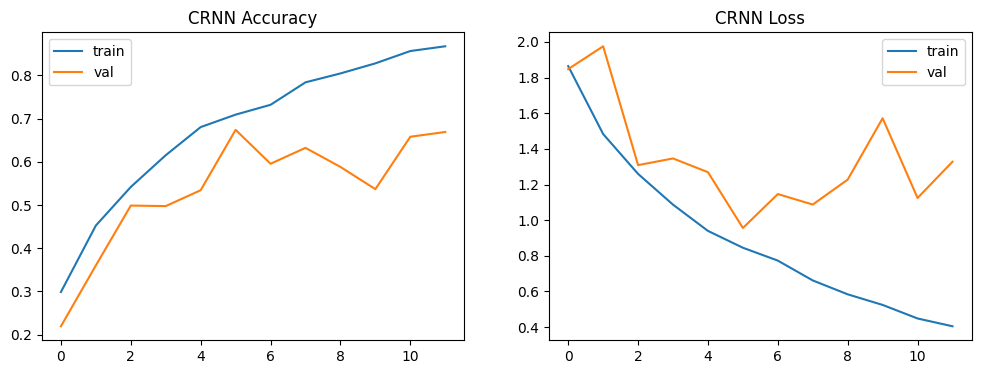

In [15]:
def build_crnn(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inp)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)

    shape = tf.keras.backend.int_shape(x)
    new_mels, new_frames, channels = shape[1], shape[2], shape[3]

    x = layers.Reshape((new_frames, new_mels * channels))(x)
    x = layers.LSTM(128)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

crnn = build_crnn(input_shape, num_classes)
hist_crnn, ckpt_crnn = train_and_save(crnn, "crnn")
plot_history(hist_crnn, "CRNN")

In [16]:
models_ckpts = {
    "baseline": ckpt_base,
    "cnn": ckpt_cnn,
    "lstm": ckpt_lstm,
    "crnn": ckpt_crnn
}

results = {}
for name, ckpt in models_ckpts.items():
    m = tf.keras.models.load_model(ckpt)
    _, val_acc = m.evaluate(X_val, y_val, verbose=0)
    print(f"{name} val_acc = {val_acc:.4f}")
    results[name] = (m, val_acc)

best_name = max(results, key=lambda x: results[x][1])
best_model = results[best_name][0]

print("\nMejor modelo según validación:", best_name)

baseline val_acc = 0.2549


cnn val_acc = 0.7377


lstm val_acc = 0.5564
crnn val_acc = 0.6740

Mejor modelo según validación: cnn



Evaluación final en test:
Test acc = 0.6941
Classification Report - cnn
                  precision    recall  f1-score   support

 air_conditioner     0.5515    0.7500    0.6356       100
        car_horn     0.7714    0.8182    0.7941        33
children_playing     0.6495    0.6300    0.6396       100
        dog_bark     0.8354    0.6600    0.7374       100
        drilling     0.7159    0.6300    0.6702       100
   engine_idling     0.4909    0.2903    0.3649        93
        gun_shot     0.9667    0.9062    0.9355        32
      jackhammer     0.7934    1.0000    0.8848        96
           siren     0.7857    0.5301    0.6331        83
    street_music     0.6500    0.9100    0.7583       100

        accuracy                         0.6941       837
       macro avg     0.7210    0.7125    0.7054       837
    weighted avg     0.6973    0.6941    0.6830       837



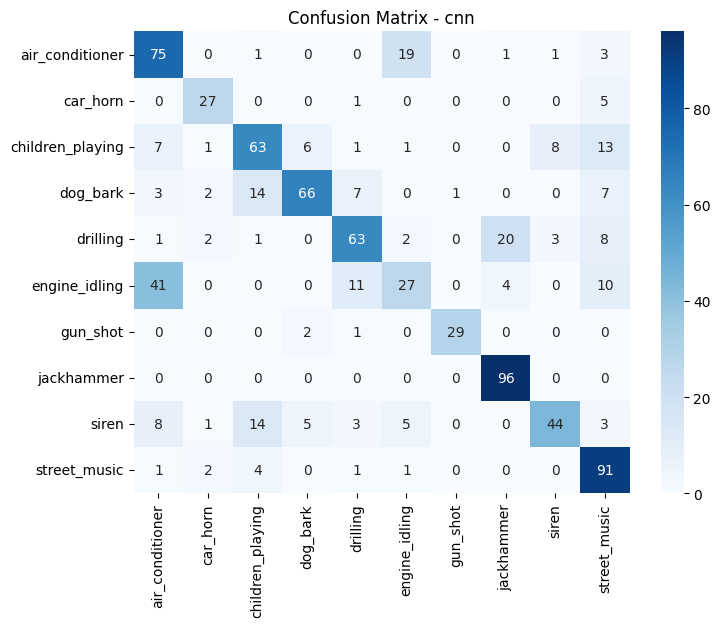

array([[6.9474197e-11, 9.9986506e-01, 2.7126720e-07, ..., 1.7549480e-08,
        1.3075010e-07, 1.5213185e-07],
       [4.9500378e-16, 1.0000000e+00, 2.0333205e-13, ..., 1.7756624e-14,
        1.6989693e-11, 1.3682080e-10],
       [1.4208305e-16, 1.0000000e+00, 1.7822321e-13, ..., 8.5664497e-16,
        7.8399530e-11, 4.8674428e-12],
       ...,
       [4.9437793e-10, 1.0124461e-04, 1.5148278e-09, ..., 4.6119377e-01,
        1.2670223e-08, 5.1022112e-06],
       [4.7085230e-10, 3.0603618e-04, 1.7938220e-08, ..., 1.6929017e-01,
        1.8275655e-07, 1.5815011e-05],
       [2.8558825e-10, 4.7516140e-05, 8.2477953e-08, ..., 6.5990813e-02,
        1.7791801e-06, 7.3392616e-06]], dtype=float32)

In [17]:
print("\nEvaluación final en test:")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test acc = {test_acc:.4f}")

evaluate_model(best_model, X_test, y_test, best_name)

In [18]:
EXPORT_DIR = "/content/models/best_final"
os.makedirs(EXPORT_DIR, exist_ok=True)

best_model.save(os.path.join(EXPORT_DIR, "best_model.keras"))
print("Modelo guardado en:", EXPORT_DIR)

# Guardar parámetros de normalización originales
np.save(os.path.join(EXPORT_DIR, "mean.npy"), np.array([params["mean"]]))
np.save(os.path.join(EXPORT_DIR, "std.npy"),  np.array([params["std"]]))

with open(os.path.join(EXPORT_DIR, "deploy_metadata.json"), "w") as f:
    json.dump({
        "class_names": class_names,
        "input_shape": input_shape
    }, f, indent=2)

print("Exportación completa.")

Modelo guardado en: /content/models/best_final
Exportación completa.


In [20]:
import tensorflow as tf
import os, shutil, tarfile

EXPORT_DIR = "/content/models/best_final"
TEMP_TAR_DIR = "/content/sagemaker_temp_export"
SM_MODEL_PATH = os.path.join(TEMP_TAR_DIR, "model")   # carpeta donde Keras exporta inicialmente

# 1) Reconstruir arquitectura y cargar pesos
weights_path = f"/content/models/{best_name}_best.weights.h5"
if best_name == "cnn":
    model_to_save = build_cnn(input_shape, num_classes)
elif best_name == "lstm":
    model_to_save = build_lstm_model(input_shape, num_classes)
elif best_name == "crnn":
    model_to_save = build_crnn(input_shape, num_classes)
elif best_name == "baseline":
    model_to_save = build_baseline(input_shape, num_classes)
else:
    raise ValueError("ERROR: best_name no reconocido")

model_to_save.load_weights(weights_path)

# 2) Directorio temporal limpio
if os.path.exists(TEMP_TAR_DIR):
    shutil.rmtree(TEMP_TAR_DIR)
os.makedirs(TEMP_TAR_DIR, exist_ok=True)

# 3) Exportar como SavedModel
model_to_save.export(SM_MODEL_PATH)   # Exporta a TEMP_TAR_DIR/model
print("Exportado SavedModel en:", SM_MODEL_PATH)

# 4) Construir estructura de versión '1/' al nivel raíz del tar
TEMP_TAR_DIR_V2 = "/content/sagemaker_temp_export_v2"
if os.path.exists(TEMP_TAR_DIR_V2):
    shutil.rmtree(TEMP_TAR_DIR_V2)
os.makedirs(os.path.join(TEMP_TAR_DIR_V2, "1"), exist_ok=True)

# Copiar SavedModel a '1/'
shutil.copy(os.path.join(SM_MODEL_PATH, "saved_model.pb"),
            os.path.join(TEMP_TAR_DIR_V2, "1", "saved_model.pb"))
shutil.copytree(os.path.join(SM_MODEL_PATH, "variables"),
                os.path.join(TEMP_TAR_DIR_V2, "1", "variables"))

# 5) Copiar artefactos adicionales al nivel raíz del tar
for fname in ["mean.npy", "std.npy", "deploy_metadata.json"]:
    shutil.copy(os.path.join(EXPORT_DIR, fname), TEMP_TAR_DIR_V2)

# Incluir los parámetros de preprocesamiento del Notebook 1
pp_json_source = "/content/drive/MyDrive/UrbanSound_Preprocessed/preprocessing_params.json"
if os.path.exists(pp_json_source):
    shutil.copy(pp_json_source, os.path.join(TEMP_TAR_DIR_V2, "preprocessing_params.json"))


# 6) Empaquetar en model.tar.gz
archive_name = "model.tar.gz"
with tarfile.open(archive_name, "w:gz") as tar:
    tar.add(TEMP_TAR_DIR_V2, arcname=".")
print("model.tar.gz listo para SageMaker:", os.path.abspath(archive_name))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/content/sagemaker_temp_export/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 173, 1), dtype=tf.float32, name='keras_tensor_278')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132846704985872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704989712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704990672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704991056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704992016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704989904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704990096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704991440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704990288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132846704990480: TensorSpec(shape=(), dtype=tf.resource, na

In [22]:
!tar -tzf model.tar.gz | sed -n '1,50p'

./
./1/
./1/saved_model.pb
./1/variables/
./1/variables/variables.data-00000-of-00001
./1/variables/variables.index
./deploy_metadata.json
./mean.npy
./preprocessing_params.json
./std.npy
